#### Run to download mergedDf.csv from google drive if your file is missing

In [37]:
# Download CSV file from google drive and save it if you haven't already
import gdown

file_id = '1ppMS80qyI0jlk3UJoxWeihBSMxqrt0ZN'
url = f'https://drive.google.com/uc?id={file_id}'
output = '../data/mergedDF.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ppMS80qyI0jlk3UJoxWeihBSMxqrt0ZN
To: C:\Users\jackk\Documents\Abroad Classes\Computational Analysis of Big Data\SqueezeNet\data\mergedDF.csv
100%|██████████| 48.1M/48.1M [00:06<00:00, 7.16MB/s]


'../data/mergedDF.csv'

#### Import all needed modules

In [16]:
# Base Tools
import pandas as pd
import numpy as np

# Custom classes
from DataPlug import DataPlug as dp
from SqueezeNet import SqueezeNet as sq

# Network tools
from sklearn.model_selection import train_test_split # Splitting the data
from sklearn.ensemble import RandomForestRegressor # Model that we are using

# Visualization Tools
from sklearn.tree import export_graphviz # Graph visualization of tree
from IPython.display import Image # Display image of tree
import pydot # Graph visualization of tree

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')

In [7]:
# Initiate instances of our custom classes
squeeze = sq("SqueezeNet")
dataPlug = dp("DataPlug")

#### Load the dataframe from a file

In [30]:
# If you want to load the mergedDF from a csv file
dataPlug.mergedDF = pd.read_csv('../data/mergedDF.csv')
dataPlug.mergedDF = dataPlug.mergedDF.drop('Unnamed: 0', axis=1)
# Drop unused column info
dataPlug.mergedDF = dataPlug.mergedDF.drop('Open', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Low', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Adj Close', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('Volume', axis=1)
dataPlug.mergedDF = dataPlug.mergedDF.drop('title', axis=1)

# Might need to keep this, not sure yet
timestamp_info = dataPlug.mergedDF['timestamp']
dataPlug.mergedDF = dataPlug.mergedDF.drop('timestamp', axis=1)

##### Take a look at the data if you'd like to

In [31]:
display(dataPlug.mergedDF)

,High,score,num_comments,Positive_Sentiment,Negative_Sentiment,Neutral_Sentiment,Compound_Sentiment
0,5.380000,13.000000,22.000000,0.000000,0.000000,1.000000,0.000000
1,5.427500,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,5.452500,1.000000,0.000000,0.205000,0.000000,0.795000,0.476700
3,5.550000,12.000000,21.000000,0.000000,0.000000,1.000000,0.000000
4,5.592500,7.000000,4.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...
2144,18.165001,1.009107,13.816064,0.139391,0.048590,0.810973,0.129618
2145,14.250000,1.596173,16.164578,0.146855,0.047587,0.804542,0.143152
2146,15.707500,3.926822,15.815921,0.153168,0.036687,0.808064,0.165109
2147,13.830000,1.809865,17.874789,0.137863,0.051644,0.808132,0.126163


#### Split the data into features/labels and testing/training sets

In [32]:
labels = np.array(dataPlug.mergedDF['High'])
dataPlug.mergedDF = dataPlug.mergedDF.drop('High', axis=1)
feature_list = list(dataPlug.mergedDF.columns)
dataPlug.features = np.array(dataPlug.mergedDF)

train_features, test_features, train_labels, test_labels = train_test_split(dataPlug.features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1611, 6)
Training Labels Shape: (1611,)
Testing Features Shape: (538, 6)
Testing Labels Shape: (538,)


#### Import and train the network

In [33]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

print(f'Training Complete! {squeeze.name} is ready to make predictions!')

Training Complete! SqueezeNet is ready to make predictions!


#### Make predictions on the test set

In [34]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.85 degrees.
Accuracy: 66.63 %.


### Save the model's full tree visualization to a file

In [13]:
# Ensure filepath sync
import os
os.makedirs('../data/tree', exist_ok=True)

In [17]:
# Path to save files to (no extension)
path_no_extension = '../data/tree/tree'

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = f'{path_no_extension}.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file(f'{path_no_extension}.dot')
# Write graph to a png file
graph.write_png(f'{path_no_extension}.png')

### Save the model's small tree visualization to a file

In [18]:
path_no_extension = '../data/tree/small_tree'

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]


# Save the tree as a png image
export_graphviz(tree_small, out_file = f'{path_no_extension}.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file(f'{path_no_extension}.dot')
graph.write_png(f'{path_no_extension}.png');

#### Display the small tree

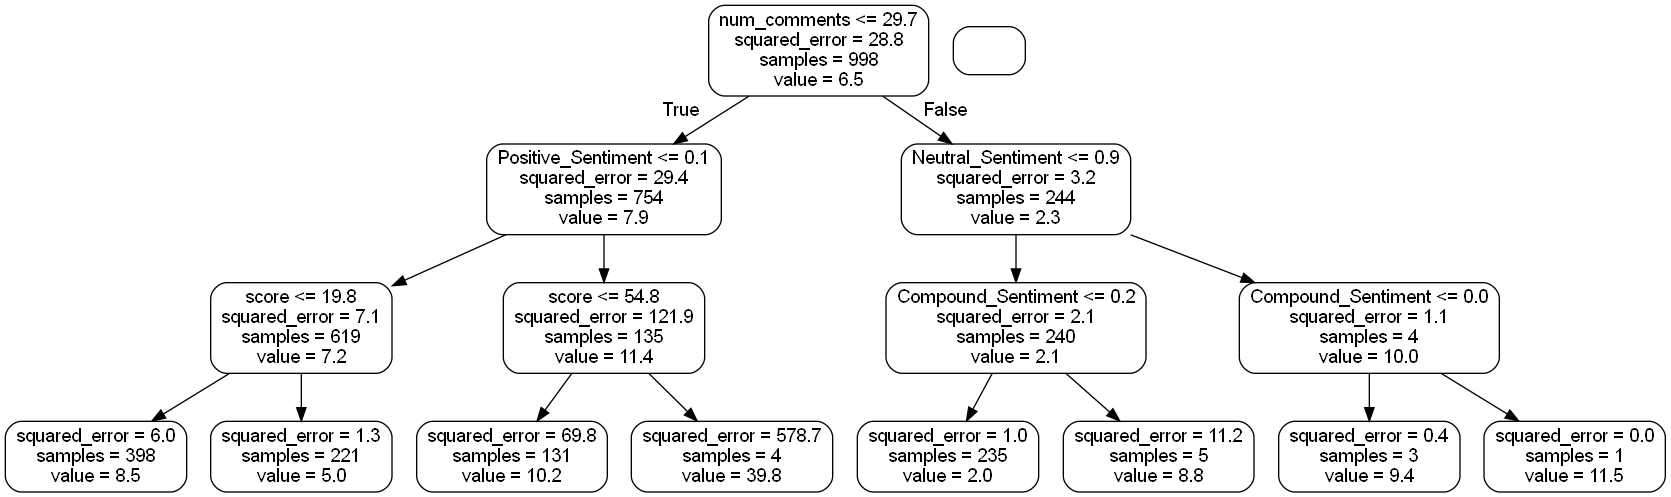

In [19]:
Image(f'{path_no_extension}.png')

#### Get numerical feature importance for the model

In [35]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: num_comments         Importance: 0.34
Variable: score                Importance: 0.32
Variable: Positive_Sentiment   Importance: 0.11
Variable: Neutral_Sentiment    Importance: 0.1
Variable: Compound_Sentiment   Importance: 0.07
Variable: Negative_Sentiment   Importance: 0.06


#### Plot the feature importances

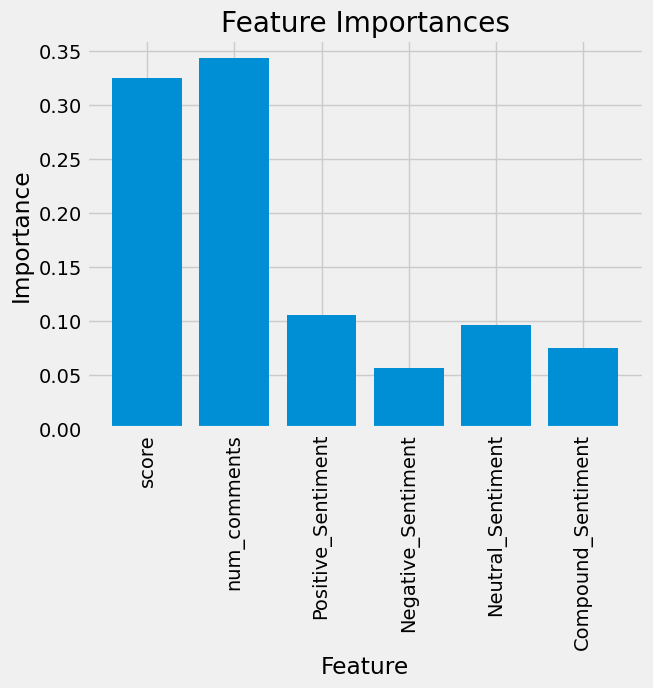

In [36]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances');

#### Plot actual vs predicted values

> Note: This section is not working yet. I'm not sure how to get the dates to work properly.
>> Reference [this article for visulization](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)

In [23]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = [date.month for date in timestamp_info]
days = [date.day for date in timestamp_info]
years = [date.year for date in timestamp_info]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('timestamp').month]
days = test_features[:, feature_list.index('timestamp').day]
years = test_features[:, feature_list.index('timestamp').year]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60');
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

AttributeError: 'str' object has no attribute 'month'